In [1]:
!pip install umap-learn -q

     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 15.0 MB/s 


# blood and heart ratio

In [94]:
!cp /content/drive/MyDrive/muscle_promoter/utils.py .
from utils import *
import pandas as pd
import numpy as np

In [95]:
blood_train = pd.read_csv('/content/drive/MyDrive/muscle_promoter/training_data/cpm_blood_trainset.txt', sep='\t', index_col=0)
heart_train = pd.read_csv('/content/drive/MyDrive/muscle_promoter/training_data/cpm_heart_trainset.txt', sep='\t', index_col=0)

blood_val = pd.read_csv('/content/drive/MyDrive/muscle_promoter/training_data/cpm_blood_testset.txt', sep='\t', index_col=0)
heart_val = pd.read_csv('/content/drive/MyDrive/muscle_promoter/training_data/cpm_heart_testset.txt', sep='\t', index_col=0)

In [96]:
def MYHratio(df):
  return np.array(df.loc['ENSG00000197616.11'] / df.loc['ENSG00000092054.12']) #ENSG00000197616.11:	MYH6, ENSG00000092054.12:	MYH7

MYH_train = MYHratio(heart_train)
MYH_val = MYHratio(heart_val)

MYH_train.shape, MYH_val.shape

((291,), (75,))

In [97]:
blood_train = np.array(blood_train).T
blood_val = np.array(blood_val).T

heart_train = np.array(heart_train).T
heart_val = np.array(heart_val).T

blood_train.shape, blood_val.shape

((291, 23075), (75, 23075))

In [98]:
#normalize and scale according to the autoencoder training
X_train = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_train.npy', allow_pickle=True)

_, X_blood_train_normalized, X_blood_val_normalized = normalize_data(X_train, blood_train, blood_val)
_, Y_heart_train_normalized, Y_heart_val_normalized = normalize_data(X_train, heart_train, heart_val)

del X_train
print(X_blood_train_normalized.shape, MYH_train.shape, "\n",
      X_blood_val_normalized.shape, MYH_val.shape)

(291, 23075) (291,) 
 (75, 23075) (75,)


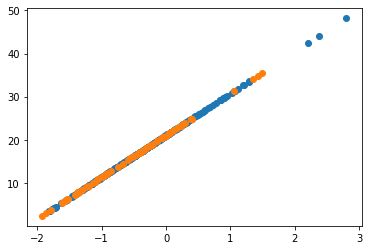

In [99]:
#validate the normalization

import matplotlib.pyplot as plt

i=1000
plt.scatter(X_blood_train_normalized.T[i], blood_train.T[i])
plt.scatter(X_blood_val_normalized.T[i], blood_val.T[i])
plt.show()

transform MYHratio to more Gaussian-like distribution

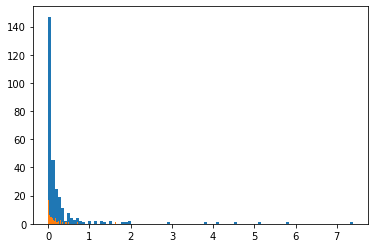

In [100]:
import matplotlib.pyplot as plt

plt.hist(MYH_train, bins=100)
plt.hist(MYH_val, bins=100)

plt.show()

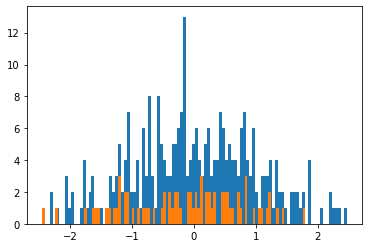

In [101]:
from sklearn.preprocessing import PowerTransformer

Y_scaler = PowerTransformer(method='box-cox')

Y_scaler.fit(MYH_train.reshape(len(MYH_train),1))

Y_heart_train=Y_scaler.transform(MYH_train.reshape(len(MYH_train),1))
Y_heart_val = Y_scaler.transform(MYH_val.reshape(len(MYH_val),1))

plt.hist(Y_heart_train, bins=100)
plt.hist(Y_heart_val, bins=100)
plt.show()

# Extract latent space

In [ ]:
from tensorflow import keras
from keras.models import Model

latent_dim=32
lr=0.001
autoencoder = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder_latent{}_lr{}.h5'.format(latent_dim,lr))

#extract encoder layers
encoder = Model(autoencoder.input, autoencoder.layers[-4].output)
encoder.summary()

In [ ]:
from sklearn.metrics import mean_squared_error

print(
    mean_squared_error(X_blood_train_normalized, autoencoder.predict(X_blood_train_normalized)),
    mean_squared_error(X_blood_val_normalized, autoencoder.predict(X_blood_val_normalized))
)

In [ ]:
X_blood_train_normalized = encoder.predict(X_blood_train_normalized)
X_blood_val_normalized = encoder.predict(X_blood_val_normalized)

print(X_blood_train_normalized.shape, X_blood_val_normalized.shape)

In [ ]:
X_blood_train_normalized[0]

# latent32 to latent8 (all data)

In [ ]:
from tensorflow import keras
from keras.models import Model

autoencoder32 = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder_latent{}_lr{}.h5'.format(32,0.001))
encoder32 = Model(autoencoder32.input, autoencoder32.layers[-4].output)

autoencoder8 = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder_latent{}_lr{}.h5'.format(8,0.001))
encoder8 = Model(autoencoder8.input, autoencoder8.layers[-4].output)

In [ ]:
X_train = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_train.npy', allow_pickle=True)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std

In [ ]:
X_train32 = encoder32.predict(X_train)
X_train8 = encoder8.predict(X_train)

In [ ]:
X_val = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_val.npy', allow_pickle=True)
X_val = (X_val - mean) / std

X_val32 = encoder32.predict(X_val)
X_val8 = encoder8.predict(X_val)

In [ ]:
X_train8[1]

array([ 8.601866 ,  2.4145143,  8.76014  ,  3.9417546, 10.353004 ,
       14.0157   ,  4.724286 , 24.215017 ], dtype=float32)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.models import Model
from keras.callbacks import Callback
from utils import r_square

def DNN_heartratio(dim_layer1=8, dim_layer2=8, l2=0.02):
  initializer = tf.keras.initializers.HeNormal()
  regularizer = tf.keras.regularizers.L2(l2)

  input = Input(shape=(32, ))
  x = Dense(dim_layer1, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)(input)
  x = Dense(dim_layer2, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  output = Dense(8, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)

  return Model(input,output)

In [ ]:
dim_layer1=16
dim_layer2=16
l2=0.01
lr=1e-3

#model_path = '/content/drive/MyDrive/muscle_promoter/heart_ratio/perceptron_embed{}_dim-{}-{}_l2{}_lr{}.h5'.format(latent_dim,dim_layer1,dim_layer2,l2,lr)

optimizer = tf.keras.optimizers.Adam(lr)
model = DNN_heartratio(dim_layer1=dim_layer1, dim_layer2=dim_layer2, l2=l2)
#model.load_weights()
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min') 
checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint.h5', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True, verbose=0)
          
history = model.fit(X_train32, X_train8, 
                    epochs=50000, batch_size=1000,
                    shuffle=True, 
                    validation_data=[X_val32, X_val8],
                    callbacks=[checkpoint, early_stop],
                    verbose=1)

Streaming output truncated to the last 5000 lines.
15/15 [==============================] - 0s 6ms/step - loss: 4.2266 - mae: 1.3502 - val_loss: 3.6963 - val_mae: 1.2717
Epoch 1234/50000
15/15 [==============================] - 0s 5ms/step - loss: 4.2184 - mae: 1.3480 - val_loss: 3.7032 - val_mae: 1.2732
Epoch 1235/50000
15/15 [==============================] - 0s 5ms/step - loss: 4.2181 - mae: 1.3478 - val_loss: 3.7021 - val_mae: 1.2726
Epoch 1236/50000
15/15 [==============================] - 0s 5ms/step - loss: 4.2310 - mae: 1.3504 - val_loss: 3.7195 - val_mae: 1.2748
Epoch 1237/50000
15/15 [==============================] - 0s 6ms/step - loss: 4.2290 - mae: 1.3496 - val_loss: 3.7115 - val_mae: 1.2749
Epoch 1238/50000
15/15 [==============================] - 0s 5ms/step - loss: 4.2201 - mae: 1.3479 - val_loss: 3.7251 - val_mae: 1.2772
Epoch 1239/50000
15/15 [==============================] - 0s 5ms/step - loss: 4.2304 - mae: 1.3513 - val_loss: 3.7160 - val_mae: 1.2750
Epoch 1240/500

In [ ]:
X_train8_pred = model.predict(X_train32)
X_val8_pred = model.predict(X_val32)

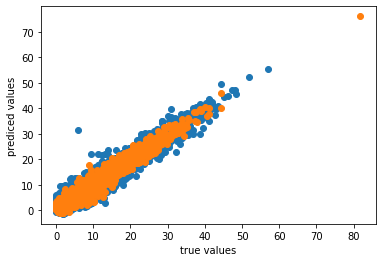

In [ ]:
import matplotlib.pyplot as plt

i=0
plt.scatter(X_train8.T[i], X_train8_pred.T[i])
plt.scatter(X_val8.T[i], X_val8_pred.T[i])
plt.xlabel('true values')
plt.ylabel('prediced values')
plt.show()


# finetune for blood32 to heart8

In [102]:
X_blood_train_normalized.shape, X_blood_val_normalized.shape, Y_heart_train_normalized.shape, Y_heart_val_normalized.shape

((291, 23075), (75, 23075), (291, 23075), (75, 23075))

In [103]:
from tensorflow import keras
from keras.models import Model

autoencoder32 = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_blood_autoencoder32.h5')
encoder32 = Model(autoencoder32.input, autoencoder32.layers[-4].output)

autoencoder8 = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_heart_autoencoder16.h5')
encoder8 = Model(autoencoder8.input, autoencoder8.layers[-4].output)

In [104]:
decoder8 = Model(autoencoder8.layers[-3].input, autoencoder8.output)
decoder32 = Model(autoencoder32.layers[-3].input, autoencoder32.output)

In [105]:
X_blood_train_normalized32 = encoder32.predict(X_blood_train_normalized)
X_blood_val_normalized32 = encoder32.predict(X_blood_val_normalized)

Y_heart_train_normalized8 = encoder8.predict(Y_heart_train_normalized)
Y_heart_val_normalized8 = encoder8.predict(Y_heart_val_normalized)

print(
    X_blood_train_normalized32.shape, X_blood_val_normalized32.shape, '\n',
    Y_heart_train_normalized8.shape, Y_heart_val_normalized8.shape
)

(291, 32) (75, 32) 
 (291, 16) (75, 16)


In [106]:
Y_heart_val_normalized8[1]

array([3.702616  , 0.3373726 , 1.1314238 , 0.        , 0.28601694,
       0.        , 2.0622585 , 0.        , 0.87016654, 1.5978203 ,
       1.086753  , 2.1995792 , 1.659124  , 0.        , 4.969574  ,
       0.        ], dtype=float32)

In [107]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X_blood_train_normalized32)

X_blood_train_normalized32 = X_scaler.transform(X_blood_train_normalized32)
X_blood_val_normalized32 = X_scaler.transform(X_blood_val_normalized32)

Y_scaler = StandardScaler().fit(Y_heart_train_normalized8)
Y_heart_train_normalized8 = Y_scaler.transform(Y_heart_train_normalized8)
Y_heart_val_normalized8 = Y_scaler.transform(Y_heart_val_normalized8)

print(
    X_blood_train_normalized32.shape, X_blood_val_normalized32.shape, '\n',
    Y_heart_train_normalized8.shape, Y_heart_val_normalized8.shape
)

(291, 32) (75, 32) 
 (291, 16) (75, 16)


In [108]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.models import Model
from keras.callbacks import Callback
from utils import r_square

def DNN(dim_layer1=8, dim_layer2=8, l2=0.02):
  initializer = tf.keras.initializers.HeNormal()
  regularizer = tf.keras.regularizers.L2(l2)

  input = Input(shape=(X_blood_train_normalized32.shape[1], ))
  x = Dense(dim_layer1, kernel_initializer=initializer, kernel_regularizer=regularizer)(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #x = Dense(dim_layer2, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  #x = BatchNormalization()(x)
  #x = Activation('relu')(x)
  output = Dense(Y_heart_train_normalized8.shape[1], kernel_initializer=initializer, kernel_regularizer=regularizer)(x)

  return Model(input,output)


dim_layer1=64
dim_layer2=32
l2=0.005
lr=1e-4

#model_path = '/content/drive/MyDrive/muscle_promoter/heart_ratio/perceptron_embed{}_dim-{}-{}_l2{}_lr{}.h5'.format(latent_dim,dim_layer1,dim_layer2,l2,lr)

optimizer = tf.keras.optimizers.Adam(lr)
model = DNN(dim_layer1=dim_layer1, dim_layer2=dim_layer2, l2=l2)
#model.load_weights('./checkpoint.h5')
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, mode='min') 
checkpoint = keras.callbacks.ModelCheckpoint('./blood32toheart8.h5', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True, verbose=0)
          
history = model.fit(X_blood_train_normalized32, Y_heart_train_normalized8, 
                    epochs=50000, batch_size=1000,
                    shuffle=True, 
                    validation_data=[X_blood_val_normalized32, Y_heart_val_normalized8],
                    callbacks=[checkpoint, early_stop],
                    verbose=1)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step - loss: 0.7251 - mae: 0.4326 - val_loss: 0.9083 - val_mae: 0.5188
Epoch 2307/50000
1/1 [==============================] - 0s 36ms/step - loss: 0.7249 - mae: 0.4325 - val_loss: 0.9082 - val_mae: 0.5188
Epoch 2308/50000
1/1 [==============================] - 0s 44ms/step - loss: 0.7247 - mae: 0.4325 - val_loss: 0.9080 - val_mae: 0.5188
Epoch 2309/50000
1/1 [==============================] - 0s 42ms/step - loss: 0.7245 - mae: 0.4324 - val_loss: 0.9079 - val_mae: 0.5188
Epoch 2310/50000
1/1 [==============================] - 0s 41ms/step - loss: 0.7243 - mae: 0.4324 - val_loss: 0.9077 - val_mae: 0.5188
Epoch 2311/50000
1/1 [==============================] - 0s 41ms/step - loss: 0.7241 - mae: 0.4323 - val_loss: 0.9076 - val_mae: 0.5188
Epoch 2312/50000
1/1 [==============================] - 0s 34ms/step - loss: 0.7239 - mae: 0.4323 - val_loss: 0.9074 - val_mae: 0.5187
Epoch 2313/50000
1/1 

In [109]:
Y_heart_train_normalized8 = Y_scaler.inverse_transform(Y_heart_train_normalized8)
Y_heart_val_normalized8 = Y_scaler.inverse_transform(Y_heart_val_normalized8)

Y_heart_val_normalized8[1]

array([3.702616  , 0.3373726 , 1.1314238 , 0.        , 0.28601694,
       0.        , 2.0622585 , 0.        , 0.87016654, 1.5978203 ,
       1.086753  , 2.1995792 , 1.659124  , 0.        , 4.969574  ,
       0.        ], dtype=float32)

In [110]:
model.load_weights('./blood32toheart8.h5')

Y_heart_train_normalized8pred = Y_scaler.inverse_transform(model.predict(X_blood_train_normalized32))
Y_heart_val_normalized8pred = Y_scaler.inverse_transform(model.predict(X_blood_val_normalized32))

heart_reconstruct_train = decoder8(Y_heart_train_normalized8pred)
heart_reconstruct_train = np.array(heart_reconstruct_train)

heart_reconstruct_val = decoder8(Y_heart_val_normalized8pred)
heart_reconstruct_val = np.array(heart_reconstruct_val)

In [86]:
Y_heart_val_normalized8pred_scale = Y_scaler.transform(Y_heart_val_normalized8pred)
Y_heart_val_normalized8_scale = Y_scaler.transform(Y_heart_val_normalized8)

In [90]:
Y_heart_val_normalized8pred_scale.shape

(75, 16)

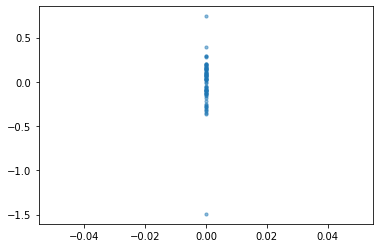

In [93]:
i=15
plt.scatter(Y_heart_val_normalized8_scale.T[i], Y_heart_val_normalized8pred_scale.T[i], s=10, alpha=.5)
#plt.plot([0,6],[0,6])
plt.show()

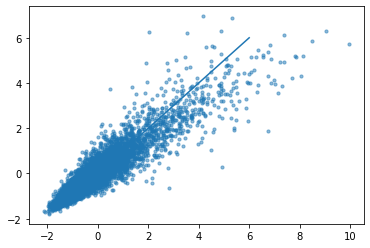

In [112]:
i=8
plt.scatter(Y_heart_val_normalized[i], heart_reconstruct_val[i], s=10, alpha=.5)
plt.plot([0,6],[0,6])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


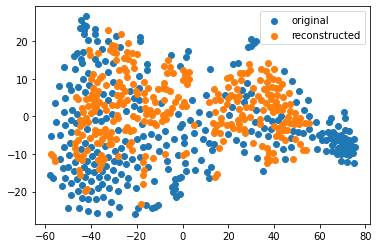

In [74]:
# tSNE for train set
from sklearn.manifold import TSNE

labels = ['original' for i in range(len(Y_heart_train_normalized))] + ['reconstructed' for i in range(len(heart_reconstruct_train))]
data = np.append(Y_heart_train_normalized,heart_reconstruct_train, axis=0)

transformer = TSNE(n_components=2, init="pca", method='exact', learning_rate="auto", random_state=0)
embeding = transformer.fit_transform(data)

import matplotlib.pyplot as plt
plt.scatter(embeding[0:len(Y_heart_train_normalized),0], embeding[0:len(Y_heart_train_normalized),1], label='original')
plt.scatter(embeding[len(Y_heart_train_normalized):len(embeding),0], embeding[len(Y_heart_train_normalized):len(embeding):,1], label='reconstructed')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


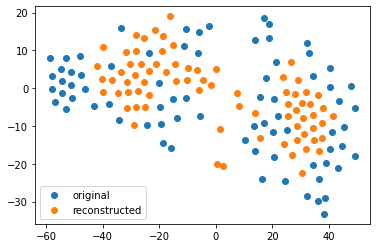

In [75]:
# tSNE for val set
from sklearn.manifold import TSNE

data = np.append(Y_heart_val_normalized, heart_reconstruct_val, axis=0)

transformer = TSNE(n_components=2, init="pca", method='exact', learning_rate="auto", random_state=0)
embeding = transformer.fit_transform(data)

import matplotlib.pyplot as plt
plt.scatter(embeding[0:len(Y_heart_val_normalized),0], embeding[0:len(Y_heart_val_normalized),1], label='original')
plt.scatter(embeding[len(Y_heart_val_normalized):len(embeding),0], embeding[len(Y_heart_val_normalized):len(embeding):,1], label='reconstructed')
plt.legend()
plt.show()


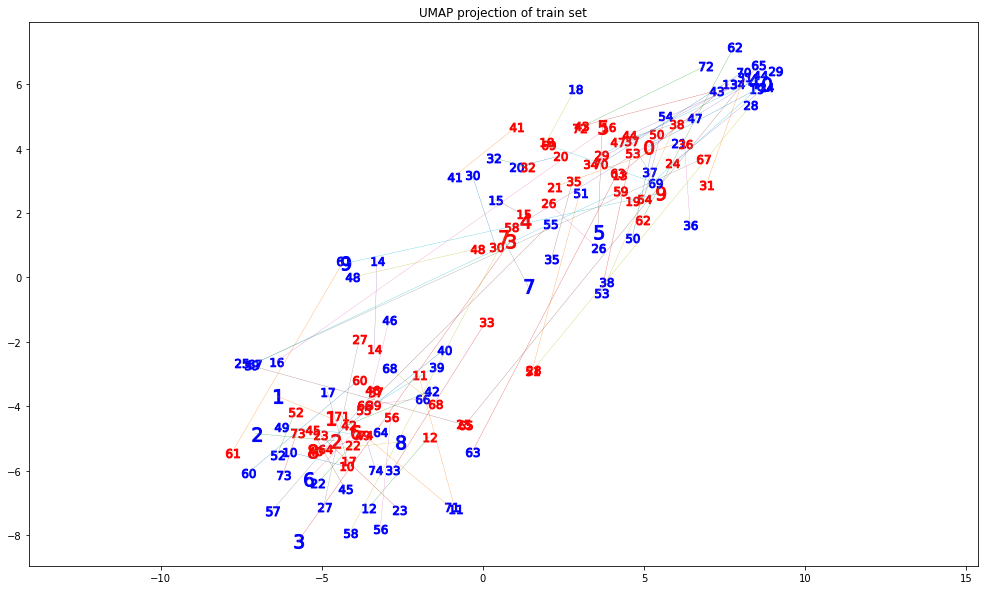

In [76]:
data_val = np.append(Y_heart_val_normalized,heart_reconstruct_val, axis=0)
embedding = TSNE(n_components=2, init="random", method='exact', learning_rate="auto", random_state=0).fit_transform(data_val)
embed_original = embedding[0:len(Y_heart_val_normalized),:]
embed_reconstruct = embedding[len(Y_heart_val_normalized):len(embedding),:]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(17, 10))
for i in range(len(embed_original)):
  plt.scatter(embed_original[i, 0],embed_original[i, 1],
              marker = f"${i}$", c='blue', s=200) 
  plt.scatter(embed_reconstruct[i, 0],embed_reconstruct[i, 1],
              marker = f"${i}$", c='red', s=200)
  plt.plot([embed_original[i,0], embed_reconstruct[i, 0]], [embed_original[i,1], embed_reconstruct[i, 1]], linewidth=0.25)
  plt.gca().set_aspect('equal', 'datalim')
  #plt.legend()
  plt.title('UMAP projection of train set', fontsize=12)

In [ ]:
!pip install scikit-network

In [83]:
from sknetwork.clustering import KMeans
KMeans().fit_transform(data_val)

/usr/local/lib/python3.7/dist-packages/sknetwork/linalg/operators.py:130: RuntimeWarning: invalid value encountered in sqrt
  self.norm_diag = diag_pinv(np.sqrt(self.weights + regularization))


ValueError: ignored

In [79]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

embedding = umap.UMAP(random_state=12).fit_transform(data)
embedding.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(732, 2)

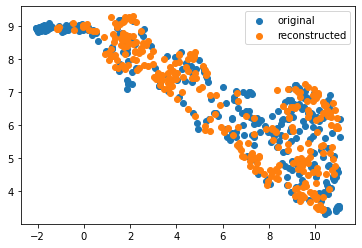

In [ ]:
plt.scatter(embedding[0:len(Y_heart_train_normalized),0], embedding[0:len(Y_heart_train_normalized),1], label='original')
plt.scatter(embedding[len(Y_heart_train_normalized):len(embedding),0], embedding[len(Y_heart_train_normalized):len(embedding):,1], label='reconstructed')
plt.legend()
plt.show()

In [77]:
data_train = np.append(Y_heart_train_normalized,heart_reconstruct_train, axis=0)
data_val = np.append(Y_heart_val_normalized, heart_reconstruct_val, axis=0)
data = np.append(data_train, data_val, axis=0)

col = [sns.color_palette()[0] for i in range(len(Y_heart_train_normalized))] \
+ [sns.color_palette()[1] for i in range(len(Y_heart_train_normalized))] \
+ [sns.color_palette()[2] for i in range(len(Y_heart_val_normalized))] \
+ [sns.color_palette()[3] for i in range(len(Y_heart_val_normalized))]

embedding = umap.UMAP(n_neighbors=30,min_dist=0.0,n_components=2,random_state=42,).fit_transform(data)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=col, s=2
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of train set', fontsize=12)

NameError: ignored

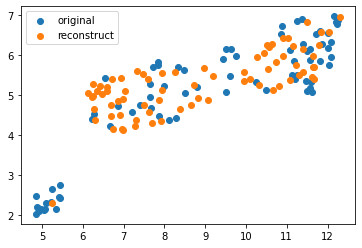

In [ ]:
plt.scatter(embed_original[:, 0],embed_original[:, 1], label='original')
plt.scatter(embed_reconstruct[:, 0],embed_reconstruct[:, 1], label='reconstruct')
#plt.plot(np.append(embed_original[:, 0], embed_reconstruct[:, 0]), np.append(embed_original[:, 1], embed_reconstruct[:, 1]))
plt.legend()
plt.show()

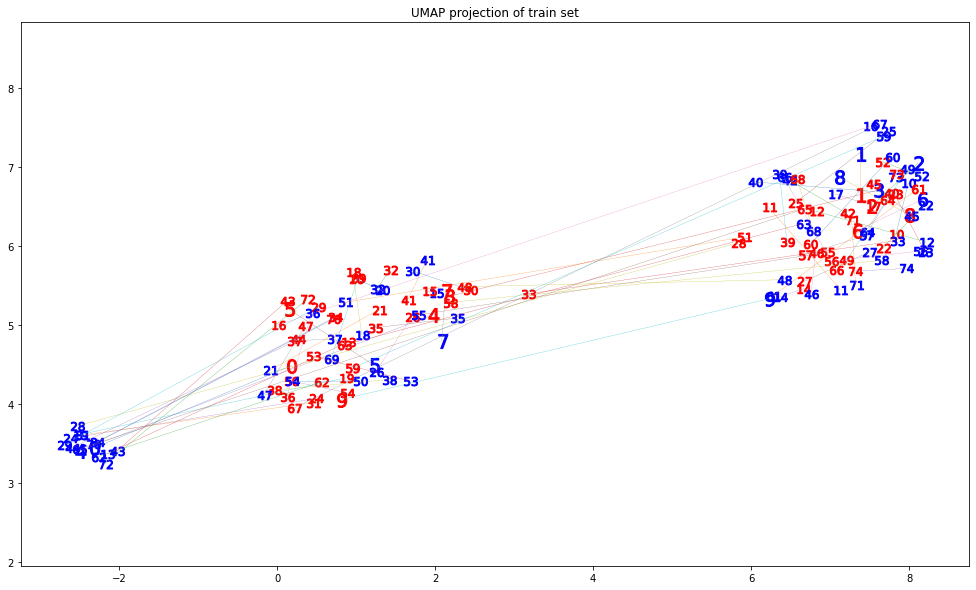

In [80]:
data_val = np.append(Y_heart_val_normalized,heart_reconstruct_val, axis=0)

embedding = umap.UMAP(n_neighbors=30,min_dist=0.0,n_components=2,random_state=42,).fit_transform(data_val)
embed_original = embedding[0:len(Y_heart_val_normalized),:]
embed_reconstruct = embedding[len(Y_heart_val_normalized):len(embedding),:]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(17, 10))
for i in range(len(embed_original)):
  plt.scatter(embed_original[i, 0],embed_original[i, 1],
              marker = f"${i}$", c='blue', s=200,cmap='Spectral') 
  plt.scatter(embed_reconstruct[i, 0],embed_reconstruct[i, 1],
              marker = f"${i}$", c='red', s=200, cmap='Spectral')
  plt.plot([embed_original[i,0], embed_reconstruct[i, 0]], [embed_original[i,1], embed_reconstruct[i, 1]], linewidth=0.25)
  plt.gca().set_aspect('equal', 'datalim')
  #plt.legend()
  plt.title('UMAP projection of train set', fontsize=12)



In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    marker = [f"${i}$" for i in marker], 
    c=col
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of train set', fontsize=12)

# Train regression from encoder latent space (Perceptron 2 layer)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.models import Model
from keras.callbacks import Callback
from utils import r_square

def DNN_heartratio(dim_layer1=8, dim_layer2=8, l2=0.02):
  initializer = tf.keras.initializers.HeNormal()
  regularizer = tf.keras.regularizers.L2(l2)

  input = Input(shape=(len(X_blood_train_normalized[1]), ))
  x = Dense(dim_layer1, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)(input)
  x = Dense(dim_layer2, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
  output = Dense(8, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)

  return Model(input,output)

In [ ]:
dim_layer1=4
dim_layer2=12
l2=0.04
lr=1e-3

#model_path = '/content/drive/MyDrive/muscle_promoter/heart_ratio/perceptron_embed{}_dim-{}-{}_l2{}_lr{}.h5'.format(latent_dim,dim_layer1,dim_layer2,l2,lr)

optimizer = tf.keras.optimizers.Adam(lr)
model = DNN_heartratio(dim_layer1=dim_layer1, dim_layer2=dim_layer2, l2=l2)
#model.load_weights()
model.compile(loss='mse', optimizer=optimizer, metrics=[r_square, 'mae'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min') 
checkpoint = keras.callbacks.ModelCheckpoint('./', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True, verbose=0)
          
history = model.fit(X_blood_train_normalized, Y_heart_train, 
                    epochs=50000, batch_size=1000,
                    shuffle=True, 
                    validation_data=[X_blood_val_normalized, Y_heart_val],
                    callbacks=[checkpoint, early_stop],
                    verbose=1)

# CONV1D

In [ ]:
X_train_selected = X_blood_train_normalized.reshape(X_blood_train_normalized.shape[0], X_blood_train_normalized.shape[1], 1)
X_val_selected = X_blood_val_normalized.reshape(X_blood_val_normalized.shape[0],X_blood_val_normalized.shape[1],1)

X_train_selected.shape, X_val_selected.shape                              #[batch_size, time_steps, input_dimension]

((291, 32, 1), (75, 32, 1))

In [ ]:
def conv1D_model():

  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(X_train_selected.shape[1],X_train_selected.shape[2])))
  model.add(keras.layers.Conv1D(filters=8, kernel_size=2, activation='relu'))
  model.add(keras.layers.MaxPooling1D(pool_size=2))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(32, activation='relu'))
  model.add(keras.layers.Dense(1))

  return model

model = conv1D_model()

optimizer = tf.keras.optimizers.Adam(5e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=[r_square, 'mae'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min') 

model.fit(X_train_selected, Y_heart_train, validation_data=[X_val_selected, Y_heart_val],
          epochs=50000, batch_size=1000,
          callbacks=[early_stop])

#lstm --> not very good


In [ ]:
def LTSM_1():
  from tensorflow.keras import layers
  inputs = keras.Input(shape=(None,), dtype="int32")
  x = layers.Embedding(latent_dim, 1)(inputs)
  
  x = layers.LSTM(64, return_sequences=True)(x)
  x = Dropout(0.5)(x)
  x = layers.LSTM(32, return_sequences=False)(x)
  x = Dropout(0.5)(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)
  return model

model=LTSM_1()

model.compile(optimizer = tf.keras.optimizers.Adam(1e-3), 
              loss="mse", metrics=[r_square, "mae"])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min') 

history = model.fit(X_blood_train_normalized, Y_heart_train, 
                    epochs=50000, batch_size=1000,
                    shuffle=True, 
                    validation_data=[X_blood_val_normalized, Y_heart_val],
                    callbacks=[early_stop],
                    verbose=1)

In [ ]:
plot_track_training_regression(history)

# add 1-2 layer on the encoder

In [ ]:
from tensorflow import keras
from keras.models import Model

latent_dim=32
lr=0.001
autoencoder = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder_latent{}_lr{}.h5'.format(latent_dim,lr))

#extract encoder layers
encoder = Model(autoencoder.input, autoencoder.layers[-4].output)
encoder.trainable = False
initializer = tf.keras.initializers.HeNormal()
regularizer = tf.keras.regularizers.L2(0.02)

input = keras.Input(shape=(X_blood_train_normalized.shape[1],))
x = encoder(input, training=False)
#x = Dense(8, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
x = Dense(16, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
output = Dense(1, kernel_initializer=initializer, kernel_regularizer=regularizer)(x) 

model = keras.Model(input, output)


model.compile(optimizer = tf.keras.optimizers.Adam(5e-4), 
              loss="mse", metrics=[r_square, "mae"])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min') 

history = model.fit(X_blood_train_normalized, Y_heart_train, 
                    epochs=50000, batch_size=1000,
                    shuffle=True, 
                    validation_data=[X_blood_val_normalized, Y_heart_val],
                    callbacks=[early_stop],
                    verbose=1)

ValueError: ignored

# validation

In [ ]:
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:


dim_layer1=4
dim_layer2=8
l2=[0.001, 0.01, 0.02, 0.05, 0.1][3]
lr=1e-4
opti='adam'

model = tf.keras.models.load_model('/content/drive/MyDrive/muscle_promoter/heart_ratio/perceptron_heart_dim_layer1-{}_dim_layer2-{}_l2-{}_lr-{}_optimizer-{}.h5'.format(dim_layer1,dim_layer2,l2,lr,opti))

0.43973520197733895


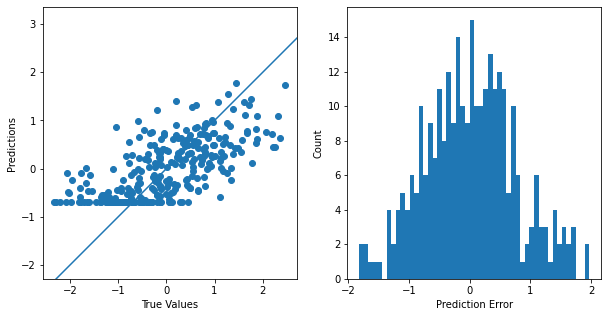

In [ ]:
plot_prediction(Y_heart_train.flatten(), model.predict(X_blood_train_normalized).flatten())
print(r2_score(Y_heart_train, model.predict(X_blood_train_normalized)))

0.2653524994126385


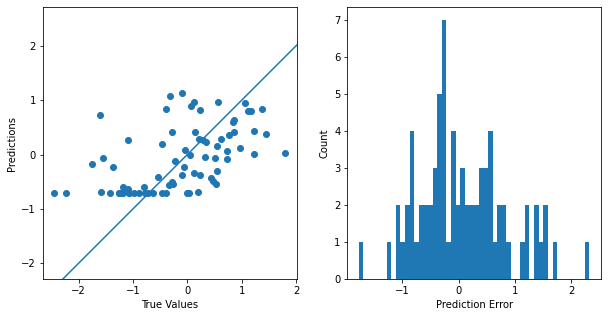

In [ ]:
plot_prediction(Y_heart_val.flatten(), model.predict(X_blood_val_normalized).flatten())
print(r2_score(Y_heart_val, model.predict(X_blood_val_normalized)))

In [ ]:
results = []

for dim_layer1 in [4,8]:
  for dim_layer2 in [2,4,8]:
    for l2 in [0.001, 0.01, 0.02, 0.05, 0.1]:
      for lr in [1e-4]:
        for opti in ['adam']:
          model = tf.keras.models.load_model('/content/drive/MyDrive/muscle_promoter/heart_ratio/perceptron_heart_dim_layer1-{}_dim_layer2-{}_l2-{}_lr-{}_optimizer-{}.h5'.format(dim_layer1,dim_layer2,l2,lr,opti))
          name = 'dim_layer1-{}_dim_layer2-{}_l2-{}_lr-{}_optimizer-{}.h5'.format(dim_layer1,dim_layer2,l2,lr,opti)
          mse_train = mean_squared_error(Y_heart_train, model.predict(X_blood_train_normalized))
          mse_val = mean_squared_error(Y_heart_val, model.predict(X_blood_val_normalized))
          r2_train = r2_score(Y_heart_train, model.predict(X_blood_train_normalized))
          r2_val = r2_score(Y_heart_val, model.predict(X_blood_val_normalized))

          results.append([name, mse_train, mse_val, r2_train, r2_val])

results = pd.DataFrame(results, columns=["name", "mse_train", "mse_val", "r2_train", "r2_val"])
results